# T-Order v. 1.0
Traveling Salesman Genetic Algorithm using x/y coordinates.

Alessandro Allegranzi

BU MET CS 767

June 12, 2024

The following implementations were used as a basis for this solution: https://medium.com/aimonks/traveling-salesman-problem-tsp-using-genetic-algorithm-fea640713758
And https://www.geeksforgeeks.org/traveling-salesman-problem-using-genetic-algorithm/

In [38]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt
import operator

# For gif of resulting routes.
import imageio.v2 as imageio


## Initializing Population

In [39]:
def create_route(city_list):
    """
    This function creates a random route of all cities in the list.
    Args:
        city_list (list): list of cities.
    Returns:
        route (list): random route.
    """
    route = random.sample(city_list, len(city_list))
    return route

def initial_population(city_list, pop_size):
    """
    This function creates an initial population of routes.
    Args:
        city_list (list): list of cities.
        pop_size (int): desired population size.
    Returns:
        population (list): initial population.
    """
    population = []
    for i in range(0, pop_size):
        population.append(create_route(city_list))
    return population

## Compute fitness and rank Solutions

In [40]:
def compute_distance(city1, city2):
    """
    This function computes the distance between two cities. Cities are placed
    on a 2 dimensional plane, so distance is calculated using the Euclidean
    distance formula on the x and y coords.
    Args:
        city1 (tuple): first city.
        city2 (tuple): second city.
    Returns:
        distance (float): distance between the two cities.
    """
    x1, y1 = city1
    x2, y2 = city2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def route_distance(route, city_coords):
    """
    Computes the total distance of a route.
    Args:
        route (list): route to be computed.
        city_coords (dict): dict of cities and coordinates.
    Returns:
        total_distance (float): total distance of the route.
    """
    total_distance = 0
    for i in range(len(route)):
        city1 = route[i]
        city2 = route[i + 1] if i + 1 < len(route) else route[0]
        total_distance += compute_distance(city_coords[city1], city_coords[city2])
    return total_distance

def rank_routes(population, city_coords):
    """
    This function ranks the routes in the population based on their fitness, and is
    the fitness function for the algo.
    Args:
        population (list): list of routes.
        city_coords (dict): dict of cities and coordinates.
    Returns:
        fitness_results (dict): dict of routes and their fitness.
    """
    fitness_results = {}
    for i in range(len(population)):
        fitness_results[i] = route_distance(population[i], city_coords)
    # sorts the fitness_results dictionary by its values in
    # ascending order and returns a list of tuples, where each tuple is
    # a key-value pair from the dictionary.
    return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = False)

## Breeding functions

In [41]:
def selection(pop_ranked, elite_size):
    """
    Implements the selection operation. Selects the best results based on
    elite_size param.
    Args:
        pop_ranked (list): list of routes and their fitness.
        elite_size (int): number of elite individuals.
    Returns:
        selection_results (list): list of selected routes.
    """
    selection_results = [pop_ranked[i][0] for i in range(elite_size)]
    for i in range(len(pop_ranked) - elite_size):
        #normalizing probabilities
        probabilities = [j[1] for j in pop_ranked]
        probabilities = [p/sum(probabilities) for p in probabilities]
        pick = int(np.random.choice(len(pop_ranked), p = probabilities))
        selection_results.append(pop_ranked[pick][0])
    return selection_results

def crossover_pool(population, selection_results):
    """
    Sets up the pool to crossover in.
    Args:
        population (list): list of routes.
        selection_results (list): list of selected routes.
    Returns:
        matingpool (list): list of mating pool.
    """
    cross_pool = [population[i] for i in selection_results]
    return cross_pool

def crossover(parent1, parent2):
    """
    This function implements the crossover operation. as described in the assignment
    it uses a single crossover point, randomly selected.
    Args:
        parent1 (list): first parent.
        parent2 (list): second parent.
    Returns:
        child (list): child of the two parents.
    """
    # Select a random crossover point.
    crossover_point = int(random.random() * len(parent1))
    child = parent1[:crossover_point]  # Copy the part of parent1 up to the crossover point.
    child += [city for city in parent2 if city not in child]  # Append the remaining cities from parent2.
    return child

def cross_population(cross_pool, elite_size):
    """
    Crosses over parents within the population.
    Args:
        cross_pool (list): list of mating pool.
        elite_size (int): number of elite individuals.
    Returns:
        children (list): list of children.
    """
    children = []
    length = len(cross_pool) - elite_size
    pool = random.sample(cross_pool, len(cross_pool))
    for i in range(0, elite_size):
        children.append(cross_pool[i])
    for i in range(0, length):
        child = crossover(pool[i], pool[len(cross_pool)-i-1])
        children.append(child)
    return children

## Mutation Functions

In [42]:
def mutate(individual, mutation_rate):
    """
    This function implements the mutation operation.
    Args:
        individual (list): individual to be mutated.
        mutation_rate (float): mutation rate.
    Returns:
        individual (list): mutated individual.
    """
    for swapped in range(len(individual)):
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual))
            city1 = individual[swapped]
            city2 = individual[swap_with]
            individual[swapped] = city2
            individual[swap_with] = city1
    return individual

def mutate_population(population, mutation_rate):
    """
    Mutates routes in the population.
    Args:
        population (list): list of individuals.
        mutation_rate (float): mutation rate.
    Returns:
        mutated_pop (list): list of mutated individuals.
    """
    mutated_pop = []
    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop

## Main algorithm function

In [43]:
def next_generation(current_gen, elite_size, mutation_rate, city_coords):
    """
    This function implements the next generation of the genetic algorithm.
    Args:
        current_gen (list): list of current population.
        elite_size (int): number of elite individuals.
        mutation_rate (float): mutation rate.
    Returns:
        next_gen (list): list of next generation.
    """
    pop_ranked = rank_routes(current_gen, city_coords)
    selection_results = selection(pop_ranked, elite_size)
    cross_pool = crossover_pool(current_gen, selection_results)
    children = cross_population(cross_pool, elite_size)
    next_gen = mutate_population(children, mutation_rate)
    return next_gen

def t_order(city_coords, pop_size, elite_size, mutation_rate, generations):
    """
    The function that runs the genetic algorithm to solve the TSP problem.

    Args:
        city_coords (dict): dict of cities and coordinates.
        pop_size (int): population size.
        elite_size (int): elite size.
        mutation_rate (float): mutation rate.
        generations (int): number of generations.
    Returns:
        best_route (list): best route.
        progress (list): list of progress.
    """
    city_list = list(city_coords.keys())
    pop = initial_population(city_list, pop_size)
    progress = []
    images = []
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate, city_coords)
        best_route_index = rank_routes(pop, city_coords)[0][0]
        best_fitness = rank_routes(pop, city_coords)[0][1]
        progress.append(best_fitness)
        # Uncomment below to see the best route calculated in each gen.
        # print(f"Generation {i}: Best fitness is {best_fitness}")

        # Plot the best route for this generation.
        best_route = pop[best_route_index]
        route = [city_coords[city] for city in best_route]
        route.append(route[0])  # to create a 'round-trip'
        xs, ys = zip(*route)
        plt.figure()
        plt.plot(xs, ys, 'xb-')
        for city in best_route:
            x, y = city_coords[city]
            plt.text(x, y, city, color="red", fontsize=12)
        filename = f'route_{i}.png'
        plt.savefig(filename)
        images.append(filename)
        plt.close()

    # Compile the images into a GIF.
    with imageio.get_writer('route.gif', mode='I') as writer:
        for filename in images:
            image = imageio.imread(filename)
            writer.append_data(image)

    best_route_index = rank_routes(pop, city_coords)[0][0]
    best_route = pop[best_route_index]
    return best_route, progress

## Setting up params for test run of algo.

In [44]:
# Define the size of the population
pop_size = 100

# Define the number of elite individuals
elite_size = 10

# Define the mutation rate
mutation_rate = 0.01

# Define the number of generations
generations = 200

# Create city coordinates for a very small sample of 5 cities.
# x = [12, 18, 20, 22, 25]
# y = [15, 18, 20, 22, 25]
# cities_names = ["Boston", "Quincy", "North Reading", "Arlington", "Needham"]
# city_coords = dict(zip(cities_names, zip(x, y)))

# Create city coords for a larger sample to better test the algorithm.
cities_names = [f"city_{i}" for i in range(1, 21)]
x = [random.randint(1, 100) for _ in range(20)]
y = [random.randint(1, 100) for _ in range(20)]
city_coords = dict(zip(cities_names, zip(x, y)))

The best calculated route is: 
 1 ['city_3', 'city_2', 'city_12', 'city_1', 'city_17', 'city_11', 'city_15', 'city_8', 'city_13', 'city_9', 'city_14', 'city_4', 'city_10', 'city_5', 'city_7', 'city_19', 'city_16', 'city_20', 'city_6', 'city_18']


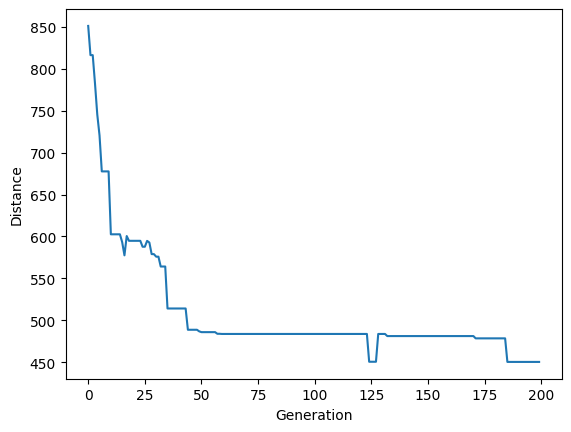

In [45]:
best_route, progress = t_order(city_coords, pop_size, elite_size, mutation_rate, generations)
print(f"The best calculated route is: \n {1}", best_route)
# Plotting the progress of the algorithm.
plt.plot(progress)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.show()

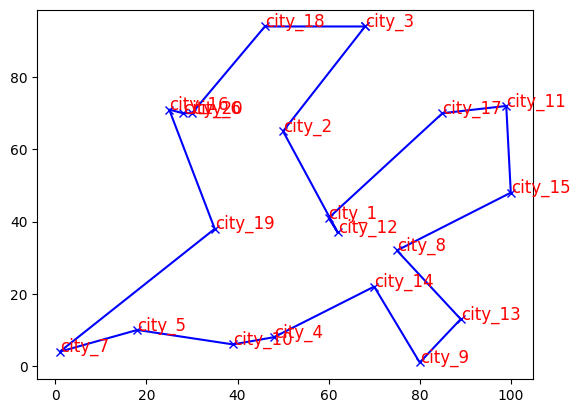

In [46]:
# The final best route results visualized

route = [city_coords[city] for city in best_route]
route.append(route[0])  # to create a 'round-trip'
xs, ys = zip(*route)
plt.figure()
plt.plot(xs, ys, 'xb-')
for city in best_route:
  x, y = city_coords[city]
  plt.text(x, y, city, color="red", fontsize=12)
plt.show()

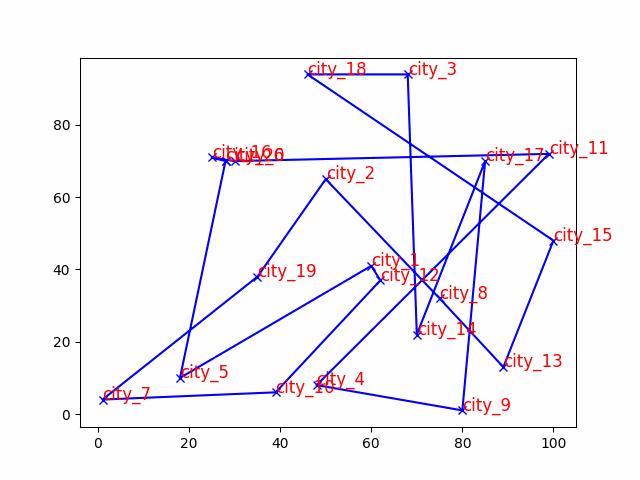

In [47]:
#gif of all best routes for each generation.

from IPython.display import Image

# Use the name of your GIF file here.
Image(open('route.gif','rb').read())